# MoutainCar Prediction using Tilecoding

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': True,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            else:
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [4]:
db = DbAccessor('hshah1_mc_pred_decay', local=False)
pd.set_option('display.max_columns', 500)
comment = 'baseline_tc'
pd.read_sql(f'select * from runs where comment="{comment}"', db.conn)

,run_id,seed,db,comment,task,net,n_timesteps,env,env_max_step_per_episode,tilecoding,tilecoding_n_tilings,tilecoding_n_tiles,net_width,net_prune_prob,imprinting_max_bound_range,step_size,meta_step_size,gamma,lmbda,epsilon
0,71746592,1,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0100,0.001,1.0,0.99,0.1
1,71746593,2,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0010,0.001,1.0,0.99,0.1
2,71746597,2,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,8,8,100,0.01,0.1,0.0001,0.001,1.0,0.99,0.1
3,71746598,2,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0001,0.001,1.0,0.99,0.1
4,71747000,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,8,8,100,0.01,0.1,0.0100,0.001,1.0,0.99,0.1
5,71747002,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0100,0.001,1.0,0.99,0.1
6,71747006,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,8,8,100,0.01,0.1,0.0010,0.001,1.0,0.99,0.1
7,71747021,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0010,0.001,1.0,0.99,0.1
8,71747041,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,8,8,100,0.01,0.1,0.0001,0.001,1.0,0.99,0.1
9,71747060,3,hshah1_mc_pred_decay,baseline_tc,prediction,expandingLFA,1000000,MountainCar-v0,0,1,24,8,100,0.01,0.1,0.0001,0.001,1.0,0.99,0.1


In [5]:
def plot_last_n(rewards_vec, predictions_vec, return_target, return_error, n=1000):
    fig, axs = plt.subplots(3, figsize=(15 , 10))
    fig.tight_layout()
    if len(rewards_vec) < n:
        n = len(rewards_vec)
    axs[0].step(list(range(n)), rewards_vec[-n:])
    axs[1].step(list(range(n)), predictions_vec[-n:], color='red', label='prediction')
    axs[1].step(list(range(n)), return_target[-n:], label='target')
    axs[2].step(list(range(n)), return_error[-n:])

    axs[0].title.set_text("reward")
    axs[1].title.set_text("predictions/target")
    axs[2].title.set_text("error sq(prediction - true target)")
    for ax in axs:
        ax.grid(color="#666666", linestyle="-", alpha=0.5)
    return fig

In [6]:
def plot_last_n_only_pred(predictions_vec, return_target, n=1000):
    fig, axs = plt.subplots(1, figsize=(15, 4))
    fig.tight_layout()
    if len(predictions_vec) < n:
        n = len(predictions_vec)
    axs.step(list(range(n)), predictions_vec[-n:], color='red', label='prediction')
    axs.step(list(range(n)), return_target[-n:], label='target')
    
    axs.title.set_text("predictions (red) / target (blue)")
    axs.grid(color="#666666", linestyle="-", alpha=0.5)
    return fig

In [7]:
def plot_runs(tmaze_len, runs):
    plt.subplot(1, 3, 1)
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('running accuracy')
    for k in runs:
        plt.plot(db.get_table('episodic_metrics', k[0], 'accuracy'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    #plt.subplot(1, 3, 2)
    #plt.title(f'T-Maze len={tmaze_len}')
    #plt.xlabel('episode')
    #plt.ylabel('running cummulative error per episode')
    #plt.yscale('log')
    #for k in runs:
    #    plt.plot(db.get_table('episodic_metrics', k[0], 'error'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    #plt.legend()
    plt.subplot(1, 3, 3)
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('num synapses')
    for k in runs:
        plt.plot(db.get_table('network_metrics', k[0], 'total_synapses'), label=f'{comment}-{k[0]} | seed:{k[1]}')
    plt.legend()
    plt.show()

In [8]:
def plot_runs_comp(tmaze_len, db_base, db_rtnn, runs_base, runs_rtnn):
    plt.title(f'T-Maze len={tmaze_len}')
    plt.xlabel('episode')
    plt.ylabel('accuracy')
    for k in runs_base:
        plt.plot(db_base.get_table('episodic_metrics', k[0], 'accuracy'), label="BPTT", color="red")
    for k in runs_rtnn:
        plt.plot(db_rtnn.get_table('episodic_metrics', k[0], 'accuracy')[0:300000], label="RTNN", color="blue")
    plt.legend()
    plt.show()

## The MSRE is around 100 here

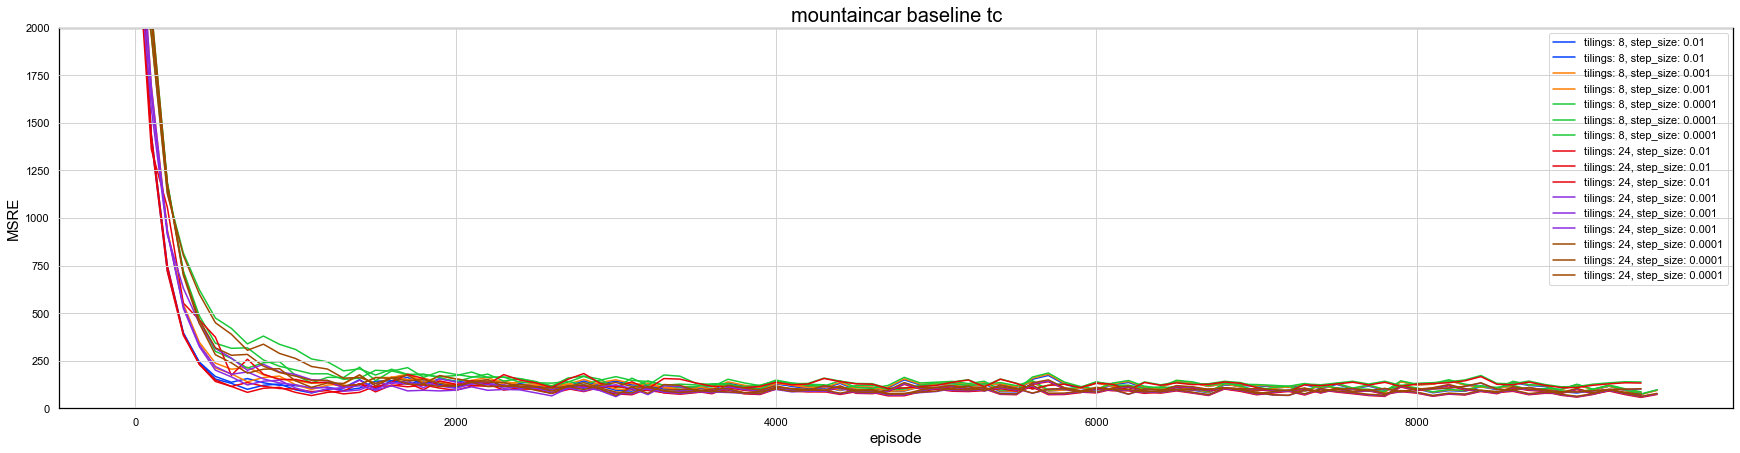

In [10]:
plt.title(f'mountaincar baseline tc')
plt.xlabel('episode')
plt.ylabel('MSRE')

colors = plt.cycler(color=sns.color_palette("bright")).by_key()['color']
color_idx = 0
for tilings, step_size in itertools.product([8,24],[0.01, 0.001, 0.0001]):
    color = colors[color_idx]
    color_idx +=1
    runs = pd.read_sql(f'select run_id from runs where comment="{comment}" and tilecoding_n_tilings={tilings} and step_size={step_size}', db.conn)
    for run in runs.values:
        plt.plot(db.get_table('episodic_metrics', run[0], 'running_MSRE'), label=f'tilings: {tilings}, step_size: {step_size}', color=color)
plt.legend()
plt.ylim(top=2000, bottom=0)

plt.show()

In [211]:
#runs = pd.read_sql(f'select run_id from runs where comment="{comment}" and tilecoding_n_tilings={8} and step_size={0.01}', db.conn).values
#for run in runs:
#    values = pd.read_sql(f'select prediction, return_target, return_error from prediction_metrics where run_id="{run[0]}" and episode=9000', db.conn).values
#    p=plot_last_n(-1*np.ones_like(values[:,0]), values[:,0], values[:,1], values[:,2], n=100)

## Tilings: 8, Tiles: 8

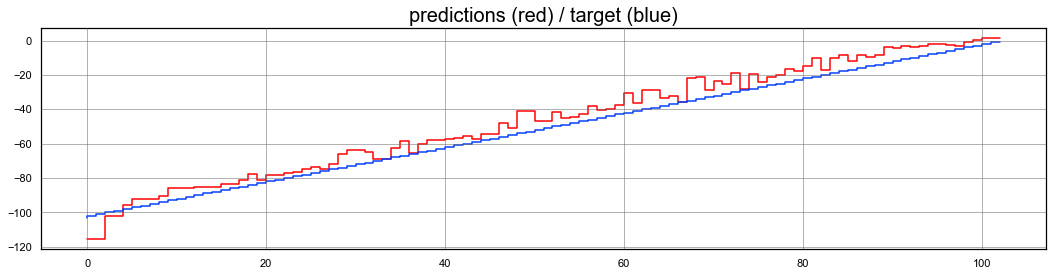

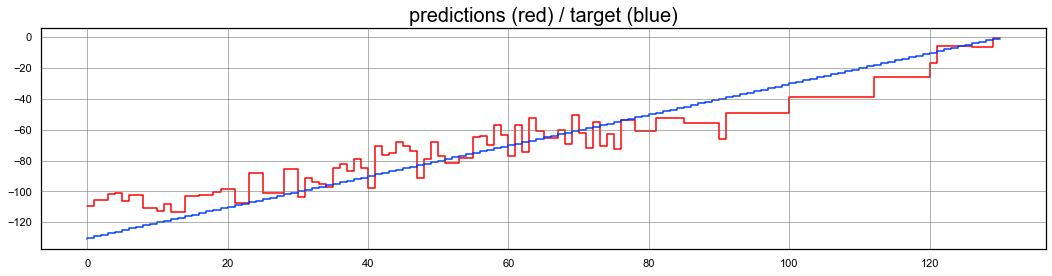

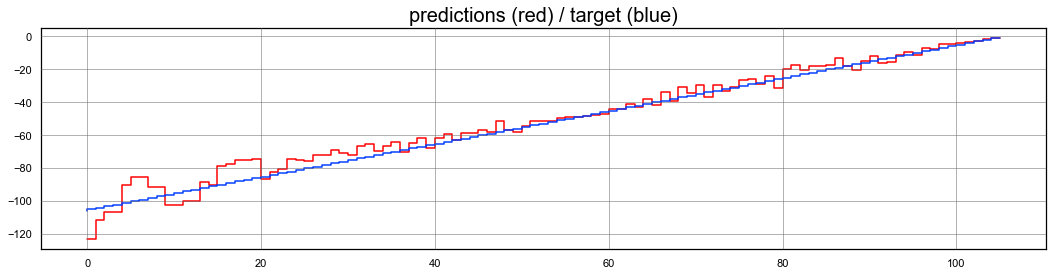

In [205]:
runs = pd.read_sql(f'select run_id from runs where comment="{comment}" and tilecoding_n_tilings={8} and step_size={0.0001}', db.conn).values
for run in runs:
    values = pd.read_sql(f'select prediction, return_target, return_error from prediction_metrics where run_id="{run[0]}" and episode=9000', db.conn).values
    p=plot_last_n_only_pred(values[:,0], values[:,1])

## Tilings: 24, Tiles: 8

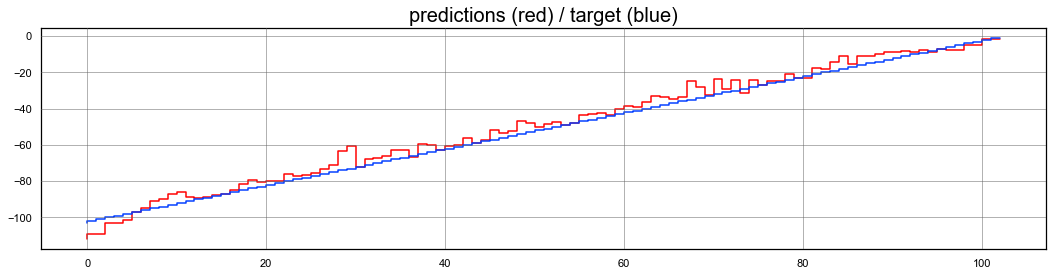

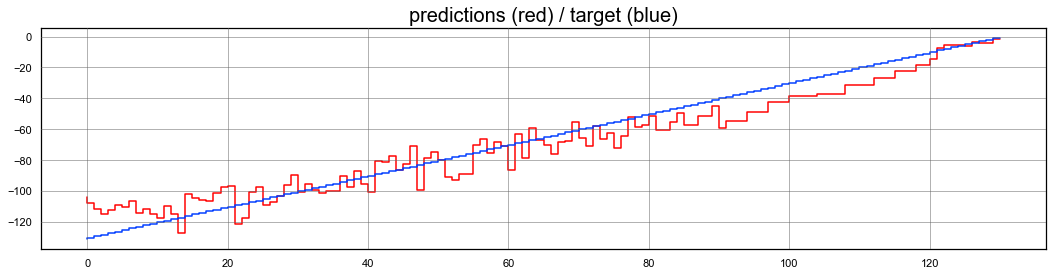

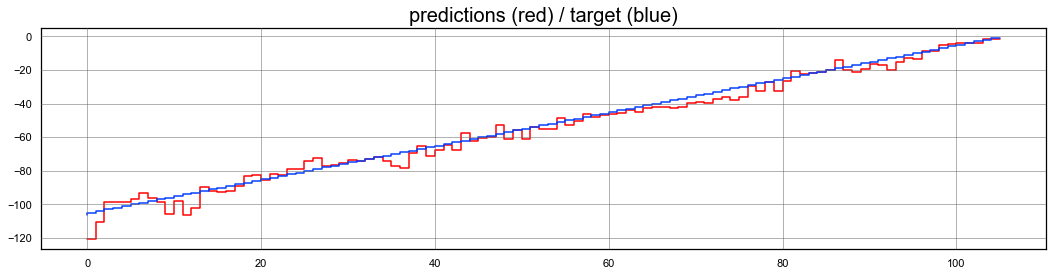

In [210]:
runs = pd.read_sql(f'select run_id from runs where comment="{comment}" and tilecoding_n_tilings={24} and step_size={0.0001}', db.conn).values
for run in runs:
    values = pd.read_sql(f'select prediction, return_target, return_error from prediction_metrics where run_id="{run[0]}" and episode=9000', db.conn).values
    p=plot_last_n_only_pred(values[:,0], values[:,1])